In [1]:
import visual
import pyrochlore
import lattice
import matplotlib.pyplot as plt
import ringflip_hamiltonian
from bit_tools import as_mask, bitperm, make_state
import numpy as np
import scipy.sparse.linalg as sLA
from sympy import Matrix

def prb_figsize(aspect_ratio = 2/3):
    width = 3.375  # inches
     # Adjust as needed (height/width)
    height = width * aspect_ratio
    return (width, height)

import os; os.chdir('/Users/alaricsanders/mygh/QSI/subspace_ED')

In [2]:
bb = ringflip_hamiltonian.BasisBenchmarker()
bb.run(10,8)

Building state tree...
Set up execution with 0 threads
Building state tree...
Set up execution with 8 threads
Thread 0 state 0x0
Thread 1 state 0x4
Thread 2 state 0x2
Thread 3 state 0x6
Thread 4 state 0x1
Thread 5 state 0x5
Thread 6 state 0x3
Thread 7 state 0x7
Building state tree...
Set up execution with 8 threads
Thread 0 state 0x0
Thread 1 state 0x4
Thread 2 state 0x2
Thread 3 state 0x6
Thread 4 state 0x1
Thread 5 state 0x5
Thread 6 state 0x3
Thread 7 state 0x7
Building state tree...
Set up execution with 8 threads
Thread 0 state 0x0
Thread 1 state 0x4
Thread 2 state 0x2
Thread 3 state 0x6
Thread 4 state 0x1
Thread 5 state 0x5
Thread 6 state 0x3
Thread 7 state 0x7
Building state tree...
Set up execution with 8 threads
Thread 0 state 0x0
Thread 1 state 0x4
Thread 2 state 0x2
Thread 3 state 0x6
Thread 4 state 0x1
Thread 5 state 0x5
Thread 6 state 0x3
Thread 7 state 0x7
Building state tree...
Set up execution with 8 threads
Thread 0 state 0x0
Thread 1 state 0x4
Thread 2 state 0x2
Threa

In [3]:
bb.estimated_runtime([[2,0,0],[0,3,0],[0,0,3]])[0] / 3600

np.float64(0.27019267345120146)

In [4]:

lat = lattice.Lattice(bravais_vectors=[[2,0,0],[0,2,0],[0,0,2]], primitive_suggestion=pyrochlore.primitive,populate=True)
lat.delete_atom_at_idx(0)
pyrochlore.export_json(lat, "lattice_files/pyro_2,0,0_0,2,0_0,0,2_d0.json")
# lat = pyrochlore.import_json("lattice_files/pyro_2,0,0_0,3,0_0,0,3_d18.json")
lat = pyrochlore.import_json("lattice_files/pyro_2,0,0_0,2,0_0,0,2_d0.json")

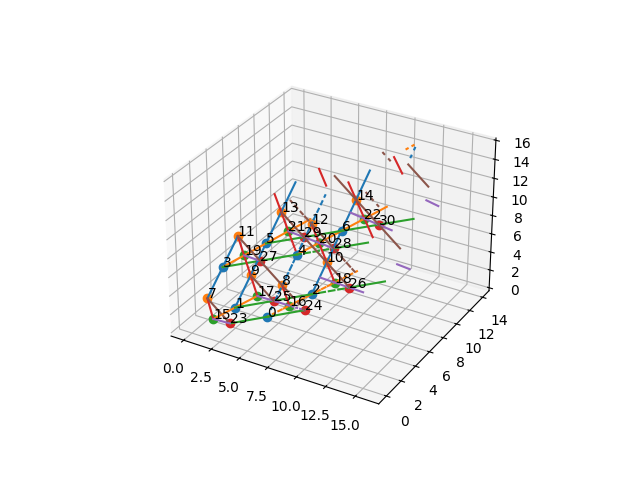

In [5]:
%matplotlib widget
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
visual.plot_atoms(ax, lat)
visual.plot_bonds(ax, lat)

# pyrochlore.export_json(lat, "lattice_files/pyro_2,0,0_0,3,0_0,0,3_d18.json")

In [6]:
from tqdm import tqdm
import numpy as np
import itertools

def calc_spinonfree_basis(lat: lattice.Lattice):
    # input -> a Lattice object
    # output -> Sz, a set of bitstrings with spins corresponding to the order of lat.atoms; the basis vectors

    N_ATOMS = len(lat.atoms)
    N_UP_TETRAS = N_ATOMS // 4
    
    T_up, T_down = pyrochlore.get_tetras(lat)
    # strategy: can tile the full lattice using up tetras
    # iterate exhaustively through the set of up tetras configs,
    # reject those that make spinons on down tetras
    states_2I2O = {4:[0b0011, 0b0101, 0b1001, 0b0110, 0b1010, 0b1100],
                   3:[0b011, 0b101, 0b001, 0b110, 0b010, 0b100],
                   2:[0b11, 0b10, 0b01, 0b00],
                   1:[0b1, 0b0]
                  }
                   
    basis = []

    B_masks = np.array([as_mask(tB.members) for tB in filter(lambda t: len(t.members) == 4, T_down)])
    sub_B_masks = np.array([as_mask(tB.members) for tB in filter(lambda t: len(t.members) == 3, T_down)])
    

    state_sets = [states_2I2O[len(t.members)] for t in T_up]

    for tetra_states in tqdm(itertools.product(*state_sets), total=6**N_UP_TETRAS):
        state = 0
        for t, t_state in zip(T_up, tetra_states):
            state |= make_state(t.members, t_state)

        good = True
        # filter out B spinons
        for tB_mask in B_masks:
            if (state & tB_mask).bit_count() != 2:
                good = False
                break
        for tB_mask in sub_B_masks:
            if (state & tB_mask).bit_count() == 0:
                good=False
                break
        if good:
            basis.append(state)

    return sorted(basis)

In [18]:
# bb = calc_spinonfree_basis(lat)
rfh = ringflip_hamiltonian.RingflipHamiltonian(lat,include_partial=True)
# %time rfh.calc_basis(recalc=True,nthread=8)
rfh.calc_basis(nthread=8)

Basis file already generated.
Importing lattice_files/pyro31_2_2_2x0,4,4b4,0,4b4,4,0b1.0.basis.csv...
Loading basis...

1 sectors | line 2969
 Sorting...
Basis stats: 1 sectors, total dim 2970


In [19]:
m, l, r = rfh.ringflips[6].mask

print(f"M {m:010b} L {l:010x} R {r:010x}")


M 10001000000000000000110010000 L 0010000100 R 0001000090


In [20]:
def show_state(ax, lat, state:int, emph=()):
    for j, a in enumerate(lat.atoms):
        assert a is not None
        c = 'k'
        if state & (1<<j):
            c = 'white'
        alph = 1.0
        if len(emph)>0 and j not in emph:
            alph = 0.4
        
        ax.plot(*a.xyz, 'o', color=c,mec='k',alpha=alph)
        ax.text(*a.xyz, j)


In [21]:
for b in rfh.basis[0]:
    if m&b == l:
        # print(f"b {b:010x} M&B {m&b:010x} L {l:010x} Flipped state: {b^m:010x}")
        try:
            ringflip_hamiltonian.search_sorted(rfh.basis[0], b^m)
        except LookupError as e:
            T_up, T_down = pyrochlore.get_tetras(lat)
            for tB in T_up:
                print(f"{tB}, n = {(as_mask(tB.members) & (b^m)).bit_count()}" )
            
            visual.plot_bonds(ax1, rfh.lattice)
            show_state(ax1, rfh.lattice, b)#,[24, 8, 28, 7, 0])
            visual.plot_bonds(ax2, rfh.lattice)
            show_state(ax2, rfh.lattice, b^m,[24, 8, 28, 7, 0])
            for rf in rfh.ringflips:
                mask, lef, rig = rf.mask
                if (mask&b == lef) or (mask&b == rig):
                    print(f"{mask & (b):010x}  mask& (b^m)= {mask & (b^mask):010x}, L= {lef:010x}, R= {rig:010x}")
            break


In [23]:
def diagonalise_mat(g_normal, g_partial):
    def g_at_ring(r:pyrochlore.Ring):
        return {6:g_normal, 5: g_partial}[len(r.members)]

    M = ringflip_hamiltonian.build_matrix(rfh, g_at_ring, 0)
    e, u = sLA.eigs(M,which='SR',k=50, ncv=200)
    sorter = np.argsort(np.real(e))
    return np.real(e[sorter]), u[:,sorter]




# Sweeping the values of g_partial

In [24]:
from tqdm import tqdm
results_e = []
results_u = []
gp_list = np.linspace(0,1,20)

for gp in tqdm(gp_list):
    e, u = diagonalise_mat(1, gp)
    results_e.append(e)
    results_u.append(u)

100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


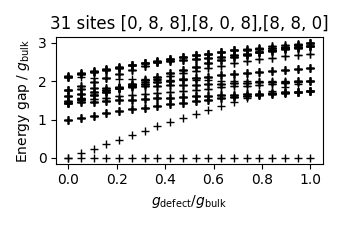

In [43]:
def make_resE_plots(ax, gp_list, results_e, results_u):

    results_e = np.array(results_e)
    
    ax.plot(gp_list, (results_e[:,:].T-results_e[:,0].T).T,'k+',ms=6)
    ax.set_xlabel(r"$g_{\rm defect}/g_{\rm bulk}$")
    ax.set_ylabel(r"Energy gap / $g_{\rm bulk}$")


fig,ax = plt.subplots(figsize=prb_figsize())
make_resE_plots(ax, gp_list, results_e, results_u)
ax.set_title(f"{lat.num_atoms} sites " + ','.join([str(list(lat.lattice_vectors[:,i])) for i in range(3)]) )
fig.tight_layout()
fig.savefig(f"/Users/alaricsanders/Desktop/defect_{lat.num_atoms}site.pdf")

In [ ]:
Sz_ops = [rfh.build_operator(0, "Z", [i]) for i in range(rfh.lattice.num_atoms)]

In [ ]:
u.shape

In [ ]:
def inner(u, op, v=None):
    if v is None:
        v = u
    return u.conj().T @ op @ v

In [ ]:
u, d = pyrochlore.get_tetras(rfh.lattice)

In [ ]:
def expectation_Sz(rfh:ringflip_hamiltonian.RingflipHamiltonian, state:np.ndarray):
    Sz_vals = np.zeros(rfh.lattice.num_atoms)
    for sector in rfh.basis:
        for psi_n, state_as_sz_string in zip(state, rfh.basis[sector]):
            weight = psi_n*np.conj(psi_n)
            for j in range(rfh.lattice.num_atoms):
                zj = 2*(state_as_sz_string & (1 << j) != 0) - 1 
                Sz_vals[j] += zj * weight
    return Sz_vals


def visualise_atom_valued_f(ax, lat:lattice.Lattice, Sz,scale=7,label_idx=True):
    assert len(Sz) == lat.num_atoms
    for i, a in enumerate(lat.atoms):
        ax.plot(*a.xyz, 'o', color=(1,1,1,1), ms=scale,mec='k')
        ax.plot(*a.xyz, 'o', color='blue' if Sz[i]<0 else 'red',
                ms=np.abs(Sz[i]) * scale,mec=None)
        if label_idx:
            ax.text(*(a.xyz+Matrix([0.3,.3,.3])), i)

def visualise_bond_valued_f(ax, lat:lattice.Lattice, f,scale=10, label_idx=True):
    assert len(f) == len(lat.bonds)
    for i, a in enumerate(lat.atoms):
        ax.plot(*a.xyz, 'o', color=(1,1,1,1), ms=10, mec='k')
        if label_idx:
            ax.text(*(a.xyz+Matrix([0.3,.3,.3])), i)
    
    for fi, b in zip(f, lat.bonds):
        x0 = lat.atoms[b.from_idx].xyz
        parts = [[x0]]
        denom = 20
        for i in range(denom):
            x = lat.wrap_coordinate(x0 + (i+1)*b.bond_delta/denom)

            if (x-parts[-1][-1]).norm() < 2*b.bond_delta.norm()/denom:
                parts[-1].append(x)
            else:
                # suggests a jump has occurred; new part
                parts.append([x])

        for link in parts:
            XX = np.array(link)[:, :, 0]
            ax.plot(*XX.T, color='red' if fi >0 else 'blue', lw=np.abs(fi)*scale)





In [ ]:
%matplotlib inline
plt.close('all')
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1, projection='3d')

e, u = diagonalise_mat(1, 0.)

# Sz = expectation_Sz(rfh, u[:,5])
Sz = [inner(u[:,0], Z) for Z in Sz_ops ]
visual.plot_bonds(ax1, rfh.lattice,
                  fmt_dict = [{'lw':1,'color':'k','zorder':-10000} for _ in range(6) ])
visualise_atom_valued_f(ax1, rfh.lattice, Sz,scale=8,label_idx=False)
ax1.view_init(elev=8., azim=-27)
# visualise_atom_valued_f(ax1, rfh.lattice, np.linspace(-1,1,31))

# Measuring the ZZ correlations

The crux of it: in the projectd maniofoldas we are, all off diag two body operators vanish

In [ ]:
ZZ_bondwise = [
    rfh.build_operator(0, "ZZ", [b.from_idx, b.to_idx])    
    for b in rfh.lattice.bonds
]

In [ ]:
%matplotlib widget
plt.close('all')
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1, projection='3d')

visualise_bond_valued_f(ax1, rfh.lattice, 
                        [inner(u[:,0], zz) for zz in ZZ_bondwise]
                        ,label_idx=True,scale=4)